In [1]:
from qml_contrastive.data_jets_graph import *

import matplotlib.pyplot as plt

Length: 100000, Info: Data(y=[1], particleid=[18, 1], h=[18, 3], num_nodes=18), Sample...: 
tensor([[ 5.3666e-04,  3.8694e-01, -8.9608e-03],
        [ 3.1963e-04, -2.2557e-01, -2.0012e-01],
        [ 2.2936e-03, -3.2403e-02, -2.4649e-01],
        [ 8.2497e-03,  2.0372e-01,  1.5876e-02],
        [ 3.3865e-03, -1.8214e-01,  4.6523e-02]])
Data(y=[1], particleid=[27, 1], h=[27, 3], num_nodes=27, edge_index=[2, 162])
Node degree: 6.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


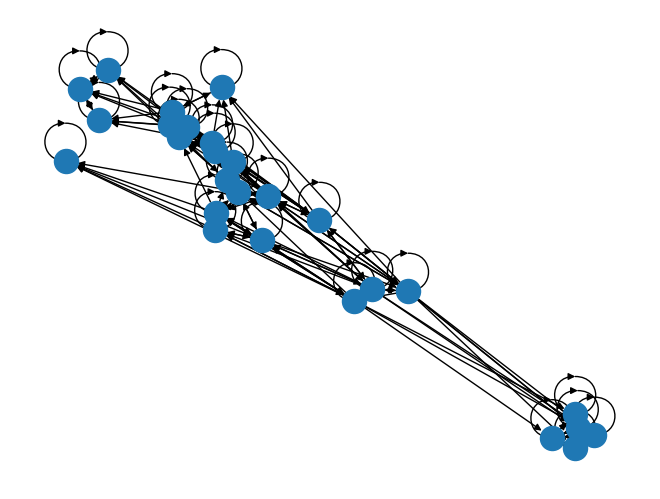

In [2]:
dataset = QG_Jets('../data/QG_Jets')
print(f"Length: {len(dataset)}, Info: {dataset[0]}, Sample...: \n{dataset[0].h[:5]}")


total_size = 100000
dataset = dataset[:total_size]

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

dataset.transform = KNNGroup(k=5, attr_name="h")
sample = dataset[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset[10]))

In [3]:
class Custom_GCN(pyg_nn.MessagePassing):
    def __init__(self, out_channels, in_channels=8):
        super().__init__(aggr='add')

        self.mlp = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, h, particleid, edge_index):
        return self.propagate(edge_index, h=h, particleid=particleid)

    def message(self, h_i, h_j, particleid_i, particleid_j):
        edge_feat = torch.cat([h_i, h_j, particleid_i, particleid_j], dim=-1)
        return self.mlp(edge_feat)
    
class GCN_Encoder(nn.Module):
    def __init__(self, hidden_dim=8):
        super().__init__()

        self.conv1 = Custom_GCN(hidden_dim)
        self.conv2 = Custom_GCN(hidden_dim, in_channels=hidden_dim*2+2)
        self.output_dim = hidden_dim
        # self.classifier = pyg_nn.MLP([hidden_dim, hidden_dim, output_dim], bias=[False, True])

    def forward(self, data):
        h, particleid, edge_index, batch = data.h, data.particleid, data.edge_index, data.batch
        
        # First Custom_GCN layer
        x = self.conv1(h=h, particleid=particleid, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(x)
        
        # Second Custom_GCN layer
        x = self.conv2(h=x, particleid=particleid, edge_index=edge_index)
        x = x.relu()
        # x = self.dropout(h)
        
        # Global Pooling:
        x = pyg_nn.global_mean_pool(x, batch)
        
        # Classifier:
        # return self.classifier(x)
        return x

import pytorch_lightning as pl    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)
batch_size = 64
from pytorch_metric_learning import losses
import torchmetrics

class ModelPL_Contrastive(pl.LightningModule):
    def __init__(self, model, learning_rate=0.01):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        # self.criterion = losses.ContrastiveLoss(pos_margin=0.25, neg_margin=5.0)
        self.criterion = losses.NTXentLoss(temperature=0.5)

        self.train_loss = torchmetrics.MeanMetric()
        self.val_loss = torchmetrics.MeanMetric()

    def forward(self, data):
        return self.model(data)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=1),
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, data, batch_idx):
        embeddings = self(data)
        loss = self.criterion(embeddings, data.y)
        self.train_loss.update(loss)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def validation_step(self, data, batch_idx):
        embeddings = self(data)
        loss = self.criterion(embeddings, data.y)
        self.val_loss.update(loss)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss

    def test_step(self, data, batch_idx):
        embeddings = self(data)
        loss = self.criterion(embeddings, data.y)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        return loss



class ModelPL_Classify(pl.LightningModule):
    def __init__(self, model, learning_rate=0.001):
        super().__init__()
        self.model = model
        self.classifier = pyg_nn.MLP([model.output_dim, 16, 2], bias=[False, True])
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        
        from torchmetrics import AUROC, Accuracy 
        self.train_auc = AUROC(task='binary')
        self.val_auc = AUROC(task='binary')
        self.test_auc = AUROC(task='binary')
        
        self.train_acc = Accuracy(task='binary')
        self.val_acc = Accuracy(task='binary')
        self.test_acc = Accuracy(task='binary')

    def forward(self, data):
        embeddings = self.model(data)
        return self.classifier(embeddings)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        lr_scheduler = {
            'scheduler': optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                        mode='min', factor=0.25, patience=1),
            'monitor': 'val_loss', 
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, data, batch_idx):
        lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.train_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("train_auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        self.train_acc(logits.argmax(dim=-1), data.y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=False, batch_size=batch_size)
        
        return loss

    def validation_step(self, data, batch_idx):
        logits = self(data)
        loss = self.criterion(logits.squeeze(), data.y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("val_auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.val_acc(logits.argmax(dim=-1), data.y)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

    def test_step(self, data, batch_idx):
        logits = self(data)
        
        self.test_auc(F.softmax(logits.squeeze(), dim=1)[:, 1], data.y)
        self.log("test_auc", self.test_auc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)
        
        self.test_acc(logits.argmax(dim=-1), data.y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_size)

Device: cuda


In [4]:
def generate_embeddings(model, data_loader):
    """
    Generate embeddings for the given data using the provided model.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): Data loader for the dataset.

    Returns:
        tuple: Embeddings and labels as numpy arrays.
    """
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for data in data_loader:
            data = data.to(model.device)
            emb = model.model(data)
            embeddings.append(emb)
            labels.append(data.y)
    
    embeddings = torch.cat(embeddings).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    
    return embeddings, labels

## Classifying Task

In [5]:
from qml_contrastive.utils import vmf_kde_on_circle, pca_proj, tsne_proj, plot_training

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

GCN_encoder = GCN_Encoder()

Graph_pl = ModelPL_Classify(model=GCN_encoder, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name='Graph_pl', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

# embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
# pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
# vmf_kde_on_circle(embeddings, labels)

trainer_dynGCNN = pl.Trainer(max_epochs=1, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

# train_result = trainer_dynGCNN.fit(Graph_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
# test_result = trainer_dynGCNN.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Reduce number of node - Preprocessing

Length: 100000, Info: Data(y=[1], particleid=[18, 1], h=[18, 3], num_nodes=18), Sample...: 
tensor([[ 5.3666e-04,  3.8694e-01, -8.9608e-03],
        [ 3.1963e-04, -2.2557e-01, -2.0012e-01],
        [ 2.2936e-03, -3.2403e-02, -2.4649e-01],
        [ 8.2497e-03,  2.0372e-01,  1.5876e-02],
        [ 3.3865e-03, -1.8214e-01,  4.6523e-02]])
Data(y=[1], particleid=[1, 1], h=[1, 3], num_nodes=1, edge_index=[2, 1])
Node degree: 1.00
Has isolated nodes: True
Has self-loops: True
Is undirected: True


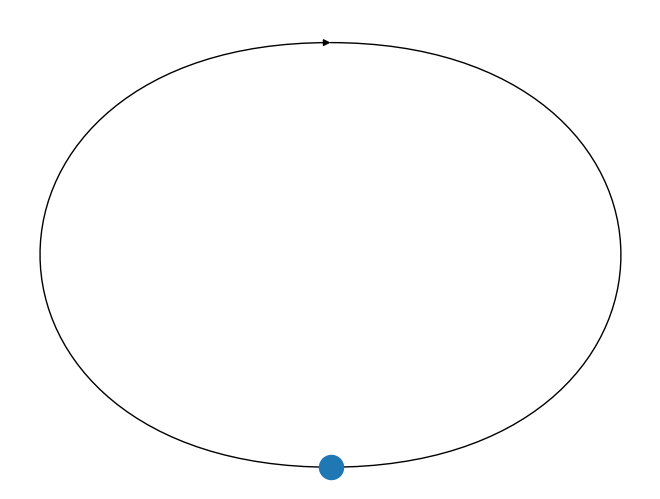

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.17it/s, loss=0.562, v_num=0, val_loss=0.566, val_auc=0.780, val_acc=0.714, learning_rate=0.0025, train_loss=0.563]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.13it/s, loss=0.562, v_num=0, val_loss=0.566, val_auc=0.780, val_acc=0.714, learning_rate=0.0025, train_loss=0.563]


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_1/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint 

Testing DataLoader 0: 100%|██████████| 313/313 [00:06<00:00, 48.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7189000248908997     │
│         test_auc          │    0.7850584983825684     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[2, 1], h=[2, 3], num_nodes=2, edge_index=[2, 4])
Node degree: 2.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


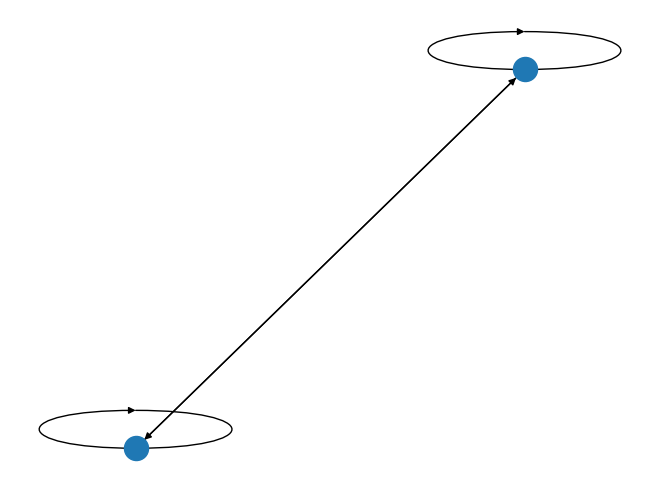

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.07it/s, loss=0.529, v_num=0, val_loss=0.545, val_auc=0.801, val_acc=0.730, learning_rate=0.0025, train_loss=0.541]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.03it/s, loss=0.529, v_num=0, val_loss=0.545, val_auc=0.801, val_acc=0.730, learning_rate=0.0025, train_loss=0.541]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_2/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_2/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:06<00:00, 49.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7357000112533569     │
│         test_auc          │     0.805496096611023     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[3, 1], h=[3, 3], num_nodes=3, edge_index=[2, 9])
Node degree: 3.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


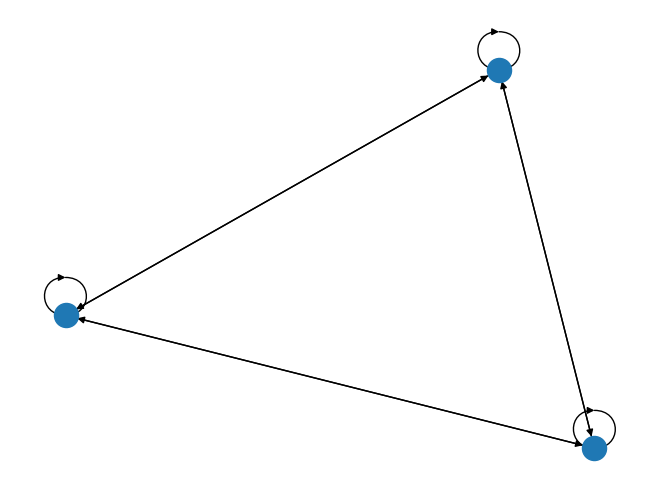

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:35<00:00, 35.11it/s, loss=0.52, v_num=0, val_loss=0.536, val_auc=0.812, val_acc=0.736, learning_rate=0.0025, train_loss=0.526] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:35<00:00, 35.07it/s, loss=0.52, v_num=0, val_loss=0.536, val_auc=0.812, val_acc=0.736, learning_rate=0.0025, train_loss=0.526]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_3/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_3/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:06<00:00, 47.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7427499890327454     │
│         test_auc          │    0.8150383234024048     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[4, 1], h=[4, 3], num_nodes=4, edge_index=[2, 16])
Node degree: 4.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


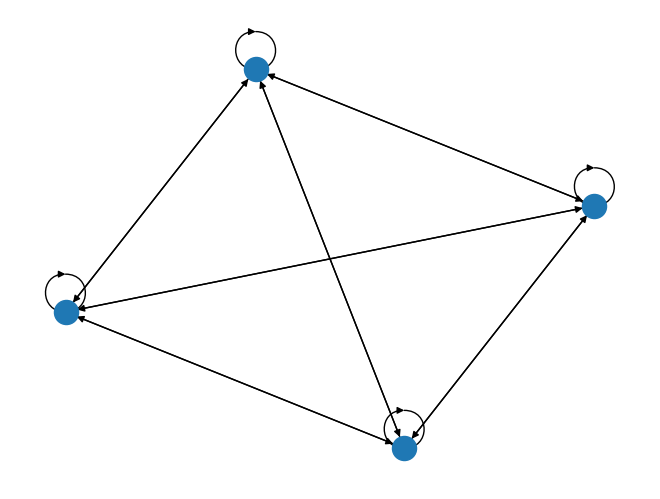

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:38<00:00, 32.08it/s, loss=0.508, v_num=0, val_loss=0.518, val_auc=0.821, val_acc=0.749, learning_rate=0.010, train_loss=0.522]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:39<00:00, 32.03it/s, loss=0.508, v_num=0, val_loss=0.518, val_auc=0.821, val_acc=0.749, learning_rate=0.010, train_loss=0.522]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_4/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_4/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:06<00:00, 45.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7576000094413757     │
│         test_auc          │    0.8293277025222778     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[5, 1], h=[5, 3], num_nodes=5, edge_index=[2, 25])
Node degree: 5.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


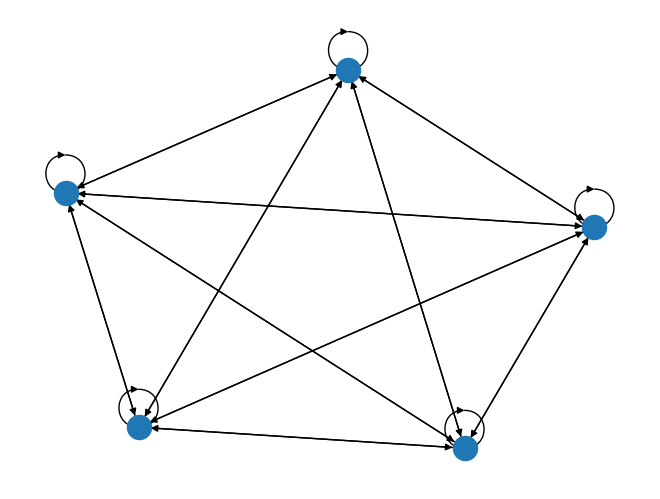

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.58it/s, loss=0.5, v_num=0, val_loss=0.507, val_auc=0.833, val_acc=0.755, learning_rate=0.010, train_loss=0.510]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.53it/s, loss=0.5, v_num=0, val_loss=0.507, val_auc=0.833, val_acc=0.755, learning_rate=0.010, train_loss=0.510]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_5/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_5/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:06<00:00, 47.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7576000094413757     │
│         test_auc          │    0.8338706493377686     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[6, 1], h=[6, 3], num_nodes=6, edge_index=[2, 36])
Node degree: 6.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


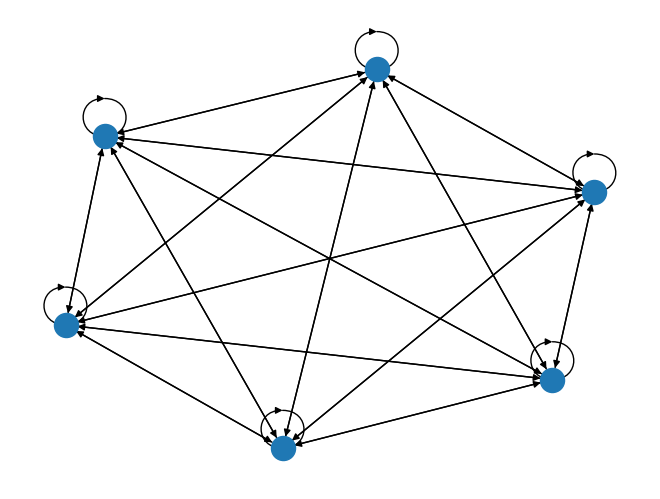

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.69it/s, loss=0.491, v_num=0, val_loss=0.508, val_auc=0.829, val_acc=0.759, learning_rate=0.0025, train_loss=0.508]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:36<00:00, 34.66it/s, loss=0.491, v_num=0, val_loss=0.508, val_auc=0.829, val_acc=0.759, learning_rate=0.0025, train_loss=0.508]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_6/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_6/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:06<00:00, 47.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7552000284194946     │
│         test_auc          │    0.8267186284065247     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[7, 1], h=[7, 3], num_nodes=7, edge_index=[2, 42])
Node degree: 6.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


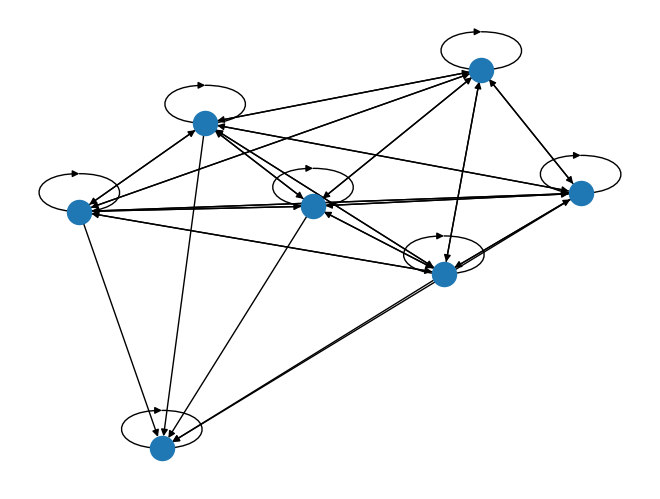

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:37<00:00, 33.81it/s, loss=0.484, v_num=0, val_loss=0.546, val_auc=0.833, val_acc=0.741, learning_rate=0.010, train_loss=0.509]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:37<00:00, 33.76it/s, loss=0.484, v_num=0, val_loss=0.546, val_auc=0.833, val_acc=0.741, learning_rate=0.010, train_loss=0.509]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_7/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_7/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:07<00:00, 40.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7376000285148621     │
│         test_auc          │    0.8321348428726196     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[8, 1], h=[8, 3], num_nodes=8, edge_index=[2, 48])
Node degree: 6.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


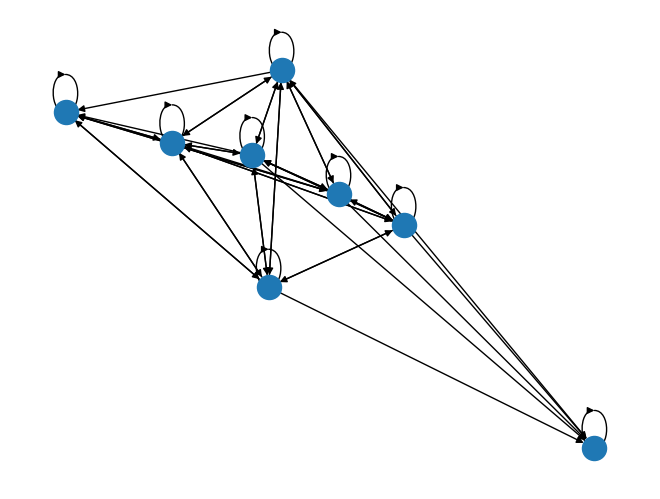

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:50<00:00, 24.81it/s, loss=0.501, v_num=0, val_loss=0.495, val_auc=0.840, val_acc=0.767, learning_rate=0.010, train_loss=0.502]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:50<00:00, 24.71it/s, loss=0.501, v_num=0, val_loss=0.495, val_auc=0.840, val_acc=0.767, learning_rate=0.010, train_loss=0.502]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_8/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_8/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:08<00:00, 36.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7652000188827515     │
│         test_auc          │    0.8405720591545105     │
└───────────────────────────┴───────────────────────────┘

Data(y=[1], particleid=[9, 1], h=[9, 3], num_nodes=9, edge_index=[2, 54])
Node degree: 6.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


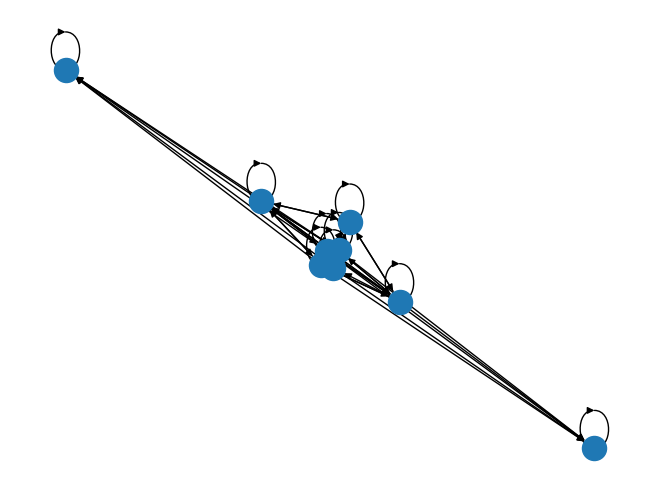

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                      | Type             | Params
----------------------------------------------------------------
0  | model                     | GCN_Encoder      | 368   
1  | model.conv1               | Custom_GCN       | 144   
2  | model.

Epoch 4: 100%|██████████| 1251/1251 [00:45<00:00, 27.40it/s, loss=0.49, v_num=0, val_loss=0.487, val_auc=0.844, val_acc=0.769, learning_rate=0.0025, train_loss=0.495] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1251/1251 [00:45<00:00, 27.29it/s, loss=0.49, v_num=0, val_loss=0.487, val_auc=0.844, val_acc=0.769, learning_rate=0.0025, train_loss=0.495]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_9/version_0/checkpoints/epoch=4-step=4690.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_9/version_0/checkpoints/epoch=4-step=4690.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:10<00:00, 28.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7685499787330627     │
│         test_auc          │    0.8432539701461792     │
└───────────────────────────┴───────────────────────────┘

In [7]:


dataset = QG_Jets('../data/QG_Jets')
print(f"Length: {len(dataset)}, Info: {dataset[0]}, Sample...: \n{dataset[0].h[:5]}")


total_size = 100000
dataset = dataset[:total_size]

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

for k in range(1, 10):
    dataset.transform = T.Compose([TopKMomentum(k=k), KNNGroup(k=5, attr_name="h")])
    sample = dataset[10]
    print(sample)

    print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
    print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
    print(f'Has self-loops: {sample.has_self_loops()}')
    print(f'Is undirected: {sample.is_undirected()}')
    nx.draw(pyg.utils.to_networkx(dataset[10]))
    plt.show()

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
    val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
    test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

    GCN_encoder = GCN_Encoder()

    Graph_pl = ModelPL_Classify(model=GCN_encoder, learning_rate=0.01)

    logger = pl.loggers.CSVLogger(save_dir='logs', name=f'graph_pl_{k}', version=0)

    summary_callback = pl.callbacks.ModelSummary(max_depth=8)
    callbacks = [summary_callback]

    # embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
    # pca_proj(embeddings, labels)
    # tsne_proj(embeddings, labels)
    # vmf_kde_on_circle(embeddings, labels)

    trainer_dynGCNN = pl.Trainer(max_epochs=5, 
                                accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                                callbacks=callbacks,
                                logger=logger,)

    train_result = trainer_dynGCNN.fit(Graph_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
    test_result = trainer_dynGCNN.test(dataloaders=test_loader)

Data(y=[1], particleid=[15, 1], h=[15, 3], num_nodes=15, edge_index=[2, 90])
Node degree: 6.00
Has isolated nodes: False
Has self-loops: True
Is undirected: False


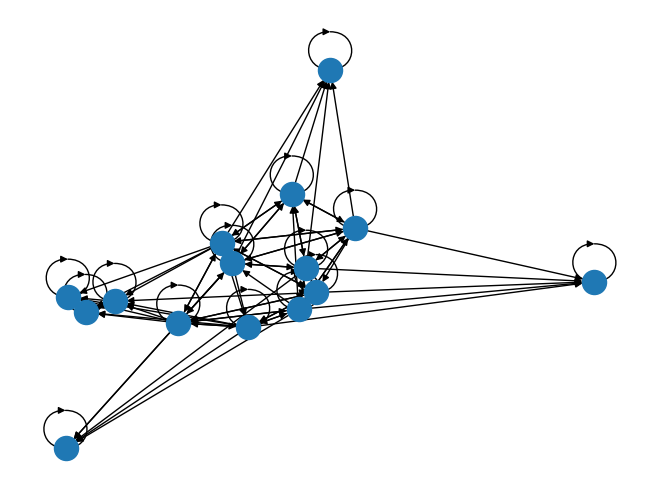

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/graph_pl_15/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty."

Epoch 9: 100%|██████████| 1251/1251 [00:35<00:00, 35.65it/s, loss=0.487, v_num=0, val_loss=0.485, val_auc=0.846, val_acc=0.779, learning_rate=0.0025, train_loss=0.494]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1251/1251 [00:35<00:00, 35.61it/s, loss=0.487, v_num=0, val_loss=0.485, val_auc=0.846, val_acc=0.779, learning_rate=0.0025, train_loss=0.494]


You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/graph_pl_15/version_0/checkpoints/epoch=9-step=9380.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/graph_pl_15/version_0/checkpoints/epoch=9-step=9380.ckpt


Testing DataLoader 0: 100%|██████████| 313/313 [00:06<00:00, 49.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7740499973297119     │
│         test_auc          │    0.8468666076660156     │
└───────────────────────────┴───────────────────────────┘

In [9]:
k = 15

dataset.transform = T.Compose([TopKMomentum(k=k), KNNGroup(k=5, attr_name="h")])
sample = dataset[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset[10]))
plt.show()

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

GCN_encoder = GCN_Encoder()

Graph_pl = ModelPL_Classify(model=GCN_encoder, learning_rate=0.01)

logger = pl.loggers.CSVLogger(save_dir='logs', name=f'graph_pl_{k}', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

# embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
# pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
# vmf_kde_on_circle(embeddings, labels)

trainer_dynGCNN = pl.Trainer(max_epochs=10, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_dynGCNN.fit(Graph_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_dynGCNN.test(dataloaders=test_loader)

graph_pl_8 8 logs/graph_pl_8/version_0/metrics.csv
graph_pl_1 1 logs/graph_pl_1/version_0/metrics.csv
graph_pl_3 3 logs/graph_pl_3/version_0/metrics.csv
graph_pl_10 10 logs/graph_pl_10/version_0/metrics.csv
graph_pl_15 15 logs/graph_pl_15/version_0/metrics.csv
graph_pl_6 6 logs/graph_pl_6/version_0/metrics.csv
graph_pl_9 9 logs/graph_pl_9/version_0/metrics.csv
graph_pl_5 5 logs/graph_pl_5/version_0/metrics.csv
graph_pl_2 2 logs/graph_pl_2/version_0/metrics.csv
graph_pl_4 4 logs/graph_pl_4/version_0/metrics.csv
graph_pl_7 7 logs/graph_pl_7/version_0/metrics.csv
[(8, 0.8405720591545105, 0.7652000188827515), (1, 0.7850584983825684, 0.7189000248908997), (3, 0.8150383234024048, 0.7427499890327454), (15, 0.8468666076660156, 0.7740499973297119), (6, 0.8267186284065247, 0.7552000284194946), (9, 0.8432539701461792, 0.7685499787330627), (5, 0.8338706493377686, 0.7576000094413757), (2, 0.805496096611023, 0.7357000112533569), (4, 0.8293277025222778, 0.7576000094413757), (7, 0.8321348428726196, 0.7

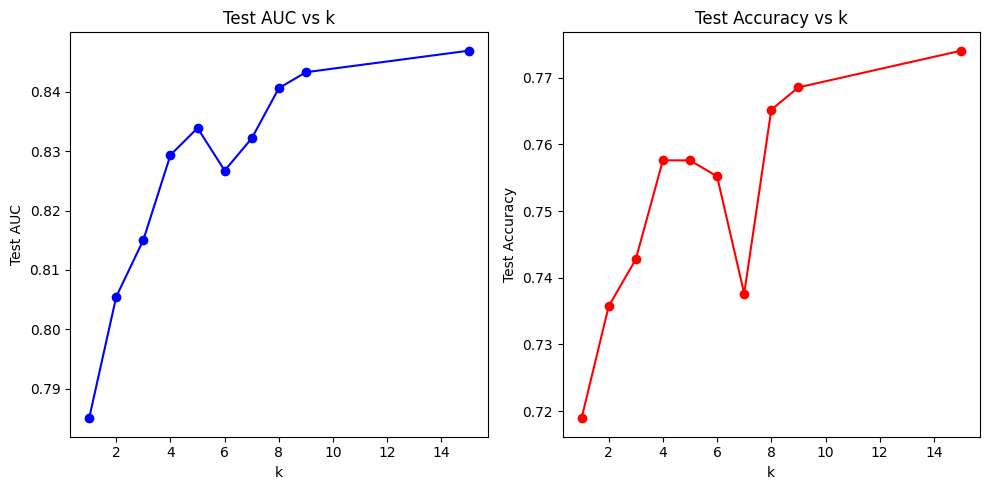

In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def extract_metrics(logs_dir='logs', prefix='graph_pl_'):
    metrics = []

    # Iterate over directories in the logs_dir
    for folder in os.listdir(logs_dir):
        
        if folder.startswith(prefix):
            
            k = int(folder[len(prefix):])  # Extract the value of k from the folder name
            metrics_file = os.path.join(logs_dir, folder, 'version_0', 'metrics.csv')
            
            print(folder, k, metrics_file)
            if os.path.exists(metrics_file):
                df = pd.read_csv(metrics_file)
                
                if 'test_auc' in df.columns and 'test_acc' in df.columns:
                    
                    # Get the last row's test_auc and test_acc
                    test_auc = df['test_auc'].dropna().values[-1]
                    test_acc = df['test_acc'].dropna().values[-1]
                    metrics.append((k, test_auc, test_acc))

    return metrics

def plot_metrics(metrics):
    metrics = sorted(metrics, key=lambda x: x[0])  # Sort by k value
    ks, test_aucs, test_accs = zip(*metrics)  # Unzip the list of tuples

    plt.figure(figsize=(10, 5))

    # Plot test AUC
    plt.subplot(1, 2, 1)
    plt.plot(ks, test_aucs, marker='o', linestyle='-', color='b')
    plt.xlabel('k')
    plt.ylabel('Test AUC')
    plt.title('Test AUC vs k')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(ks, test_accs, marker='o', linestyle='-', color='r')
    plt.xlabel('k')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs k')

    plt.tight_layout()
    plt.show()
    
# logs_dir = 'logs'
# prefix = 'graph_pl'
metrics = extract_metrics()
print(metrics)
plot_metrics(metrics)

## Contrastive Task

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


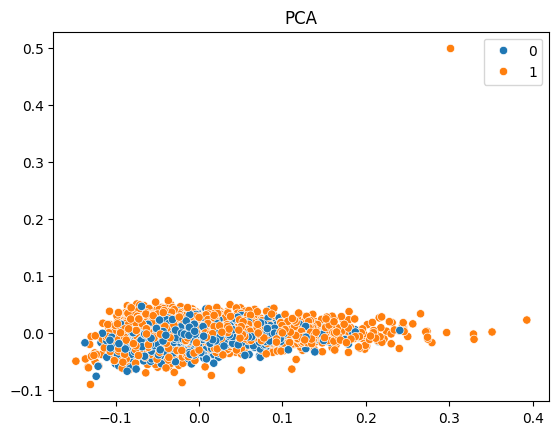

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:74: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="T-SNE")


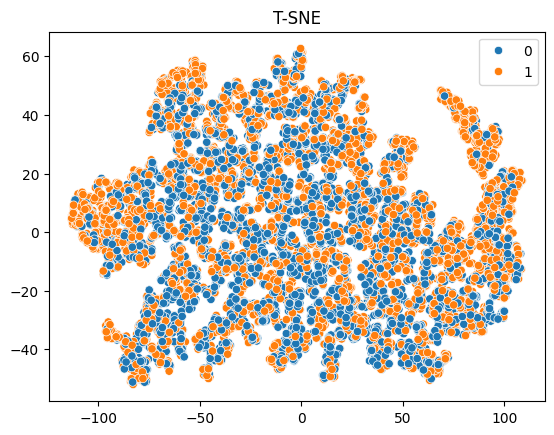

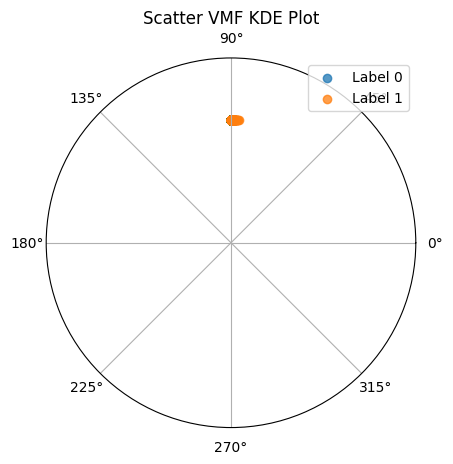

In [ ]:
from qml_contrastive.utils import vmf_kde_on_circle, pca_proj, tsne_proj, plot_training

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 12)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 12)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 12)

GCN_Encoder = GCN_Encoder()

Contrastive_Graph_pl = ModelPL_Contrastive(model=GCN_Encoder, learning_rate=0.001)

logger = pl.loggers.CSVLogger(save_dir='logs', name='Contrastive_Graph_pl', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
pca_proj(embeddings, labels)
tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


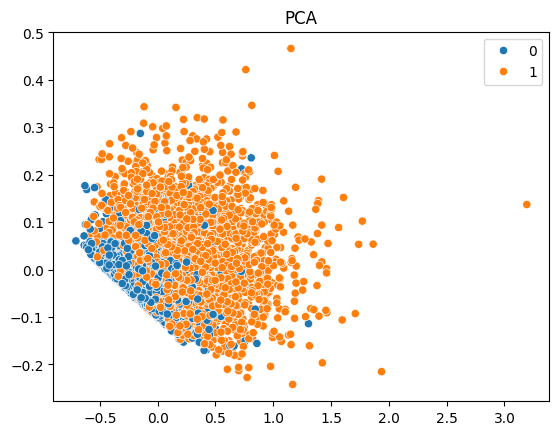

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:74: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="T-SNE")


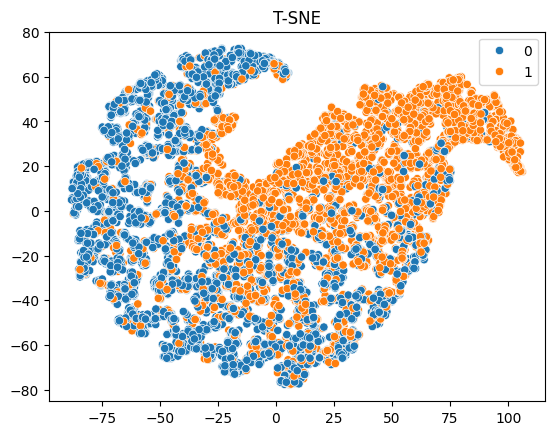

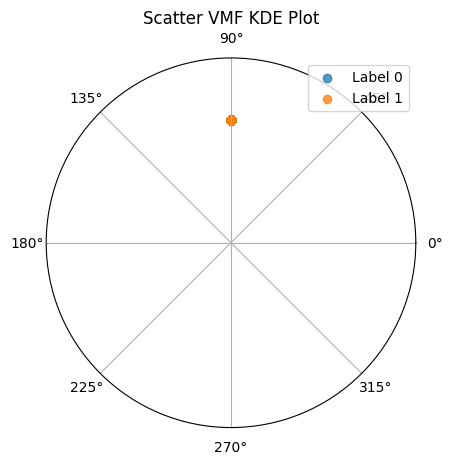

In [ ]:
embeddings, labels = generate_embeddings(Graph_pl, val_loader)
pca_proj(embeddings, labels)
tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

In [ ]:
trainer_dynGCNN = pl.Trainer(max_epochs=15, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_dynGCNN.fit(Contrastive_Graph_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_dynGCNN.test(dataloaders=test_loader)

In [ ]:
embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
pca_proj(embeddings, labels)
tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)